In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc

from numpy.fft import rfft

from scipy.optimize import least_squares as ls
from scipy.optimize import basinhopping as bh


In [2]:
rc('text', usetex=False)
rc('font', serif ='Times')
rc('font', size=16)
rc('axes', linewidth=0.5)
rc('lines', linewidth=1.15)
rc('grid', c='0.5', ls='--', lw=0.5)

rc('figure', figsize=(8.3,5.2))

In [3]:
SP2 = 48


def read_twiss(filename, header):
    
    twiss = open(filename)  # This file updates every time of madx running

    s, sbpm, beta, betabpm, phasebpm = list(), list(), list(), list(), list()

    for i,line in enumerate(twiss):
        line=line.strip()
        line=line.split()
        if line[1] == 'Q1':
            tuneX = float(line[3])
        if line[1] == 'Q2':
            tuneY = float(line[3])
        if i > header:
            s.append(float(line[2]))
            beta.append(float(line[6])) 
            if 'DX1' in line[0]:
                sbpm.append(float(line[2]))
                betabpm.append(float(line[6]))
                phasebpm.append(2*np.pi*float(line[10]))

    twiss.close()
    return tuneX, tuneY, s, sbpm, beta, betabpm, phasebpm

Q1, Q2, svar, sbpm, betamod, betabpm, phasebpm = read_twiss('twiss.txt',SP2)

M = len(betabpm)           # Number of BPMs


s_inter = np.linspace(svar[0], svar[-1], len(svar)*2)
beta_inter = np.interp(s_inter, svar, betamod, period = 54.17782237/6.)


print('horizontal tune (from TWISS)  is {}'.format(Q1))
print('vertical tune (from TWISS) is {}'.format(Q2))


phasemod = list()
for i in range(1,M):
    phasemod.append(phasebpm[i]-phasebpm[i-1])
#    phasemod2.append(phasebpm2[i]-phasebpm2[i-1])

horizontal tune (from TWISS)  is 2.40122631
vertical tune (from TWISS) is 2.460439793


In [4]:
# BPM data reading

# MADX tracking
def bpm_data_madx(filename, n_bpm, header):
    f = open(filename)

    k=0
    x,y = list(),list()
    for i,line in enumerate(f):
        if i > SP and i%2!=1:
            k = k+1
            if k%(M+1) != 0:
                line=line.strip()
                line=line.split()
                x.append(float(line[2]))
                y.append(float(line[4]))
                
    f.close()


    N = k//(M+1) # Number of turns
    A = max(x) # Amplitude. If the orbit is zero
    print('Number of turns = {}, number of BPMs = {}'.format(N,M))

    x = np.reshape(x, (N,M))
    mx = np.transpose(x)

    y = np.reshape(y, (N,M))
    my = np.transpose(y)
    
    return mx,my

# ===============================================
# space for the method to parse cryring bpms data
# ===============================================

SP = 54          # lines without info of track in trackone file 
fname = 'record.txtone'

bx,by = bpm_data_madx(fname,M,SP)

Number of turns = 500, number of BPMs = 8


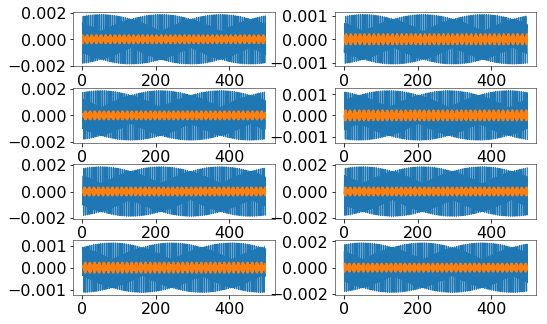

In [5]:


# data verification

# plot beam histories
K = M//2+1 if M%2!=0 else M//2

fig, axs = plt.subplots(K, 2)
fig.subplots_adjust(hspace=0.4,wspace = 0.3)
[axs[i//2,0].plot(bx[i]) if not i%2 else axs[i//2,1].plot(bx[i]) for i in range(M)]
[axs[i//2,0].plot(by[i]) if not i%2 else axs[i//2,1].plot(by[i]) for i in range(M)]
plt.show()



In [6]:
spec_x = [np.abs(rfft(x)) for x in bx]
spec_y = [np.abs(rfft(y)) for y in by]

q = np.linspace(0,0.5, len(spec_x[0]))

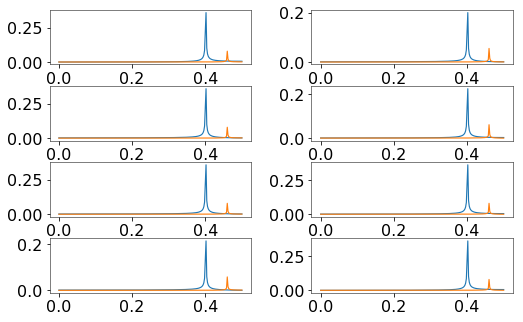

In [7]:
fig, axs = plt.subplots(K, 2)
fig.subplots_adjust(hspace=0.4,wspace = 0.3)
[axs[i//2,0].plot(q,spec_x[i]) if not i%2 else axs[i//2,1].plot(q,spec_x[i]) for i in range(M)]
[axs[i//2,0].plot(q,spec_y[i]) if not i%2 else axs[i//2,1].plot(q,spec_y[i]) for i in range(M)]
plt.show()

In [8]:
# Singular Value Decomposition
Ux, sx, Vx = np.linalg.svd(np.transpose(bx), full_matrices=True)
Uy, sy, Vy = np.linalg.svd(np.transpose(by), full_matrices=True)

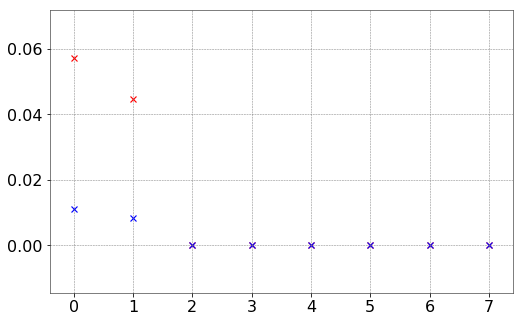

In [9]:
plt.scatter(range(len(sx)), sx, marker = 'x', color = 'red')
plt.scatter(range(len(sy)), sy, marker = 'x', color = 'blue')
plt.grid(True)
plt.show()

In [10]:
# Spectra analysis

ux = np.transpose(Ux)
uy = np.transpose(Uy)
#ux = Ux
#uy = Uy

mode_x = sx[0]*ux[0]+sx[1]*ux[1]
mode_y = sy[0]*uy[0]+sy[1]*uy[1]

# FFT block
spec_mode_x = np.abs(np.fft.rfft(mode_x))
spec_mode_y = np.abs(np.fft.rfft(mode_y))

nu_x_fft = q[np.argmax(spec_mode_x)]
nu_y_fft = q[np.argmax(spec_mode_y)]

print('Betatrone tunes. Horizontal: {} Vertical: {}'.format(nu_x_fft,nu_y_fft))

Betatrone tunes. Horizontal: 0.402 Vertical: 0.46


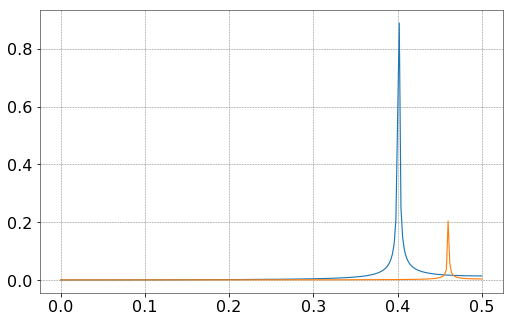

In [11]:
plt.plot(q,spec_mode_x)
plt.plot(q,spec_mode_y)
plt.grid(True)
plt.show()

In [12]:
# Naff block

# naff function
def naff(alpha, arr):

    n = np.arange(0,len(arr))    
    tmp =np.dot(arr, np.exp(2*np.pi*1j*n*alpha))

    return np.sqrt(2.0)*tmp/len(arr)

# the method returns amplitude of naff function
# it's required to find betatron tune
def ampl_naff(alpha, arr):
    tmp = naff(alpha, arr)
    return -np.abs(tmp)

# returns arg(naff) 
# it's required to find betatron phase
def phase_naff(alpha, arr):
    tmp = naff(alpha, arr)
    return np.angle(tmp)

# The method returns the betatron tune
# It finds the global max of |naff| and returns its position
def naff_tune(mode, interval, nu0):

    arg = (mode,)
    d = {}
    d["method"] = 'L-BFGS-B'
    d["args"] = arg
    vec = bh(ampl_naff, nu0, minimizer_kwargs =d)
    
    if int(vec.x[0]):
        a = np.abs(vec.x[0]%int(vec.x[0]))
    else:
        a = np.abs(vec.x[0])
        
    if a <= interval[0]:
        print('local minimum {}'.format(a))
        naff_tune(mode, interval, nu0)
    if a >= interval[1]:
        print('local minimum {}'.format(a))
        naff_tune(mode, interval, nu0)
    
    return a

In [18]:
inter_x = [nu_x_fft-1/len(mode_x),nu_x_fft+1/len(mode_x)]
inter_y = [nu_y_fft-1/len(mode_y),nu_y_fft+1/len(mode_y)]

nu_x_naff = naff_tune(mode_x, inter_x, nu_x_fft)
nu_y_naff = naff_tune(mode_y, inter_y, nu_y_fft)

print("Betatron tunes (NAFF). Horizontal {}, Vertical {}".format(nu_x_naff, nu_y_naff))

Betatron tunes (NAFF). Horizontal 0.4012314664889025, Vertical 0.46043917939078316


In [19]:
d_fft = np.sqrt((nu_x_fft - Q1%int(Q1))**2 + (nu_y_fft - Q2%int(Q2))**2)
d_naff = np.sqrt((nu_x_naff - Q1%int(Q1))**2 + (nu_y_naff - Q2%int(Q2))**2)

print('difference between fft and naff d_fft {} d_naff {}'.format(d_fft, d_naff))

difference between fft and naff d_fft 0.0008899517396739296 d_naff 5.1928695410717016e-06


In [20]:
# Betatron phase calculations

# naff
phi = [phase_naff(nu_x_naff, x) for x in bx]
# mia
phase = [np.arctan(sx[1]*Vx[1][i]/(sx[0]*Vx[0][i])) for i in range(0,M)]

# wrap the phase

# naff
phi_naff = list() 
for i in range(1,M):
    d = -phi[i]+phi[i-1]
    if d < 0:
        d+=2*np.pi
    phi_naff.append(d)

# mia
phi_mia = list()
for i in range(1,M):
    d = -phase[i]+phase[i-1]
    if d< 0:
        d+=np.pi
    phi_mia.append(d)
    
phi_mia[1] +=np.pi



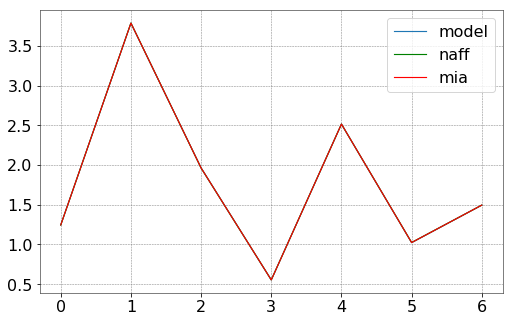

In [38]:
plt.plot(phasemod, label='model')
plt.plot(phi_naff, color = 'green', label= 'naff')
plt.plot(phi_mia, color = 'red', label='mia')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
beta_x = sx[0]**2*(Vx[0]**2)+sx[1]**2*(Vx[1]**2)
beta_y = sy[0]**2*(Vy[0]**2)+sy[1]**2*(Vy[1]**2)

In [27]:
def find_scaling(kappa, meas, model):
    return np.abs(kappa*np.array(meas) - np.array(model))
    

In [34]:
arg = (beta_x, betabpm)

vec = ls(find_scaling, 1.0, args=arg)
kappa_x = vec.x[0]

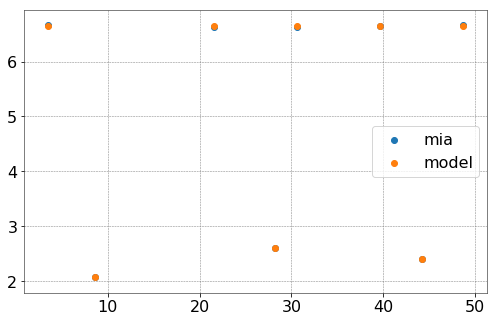

In [40]:
plt.scatter(sbpm, kappa_x*beta_x, label='mia')
plt.scatter(sbpm,betabpm, label='model')
plt.legend()
plt.grid(True)
plt.show()